In [1]:
from fastai.vision import *
from sklearn.datasets import make_moons, make_blobs, make_circles, make_classification
import seaborn as sns
import pdb
import contextlib
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
path = untar_data(URLs.MNIST)

In [3]:
class MixMatchImageList(ImageList):
    def filter_train(self,num_items,seed=2343):
        train_idxs = np.array([i for i,o in enumerate(self.items) if Path(o).parts[-3] != "testing"])
        valid_idxs = np.array([i for i,o in enumerate(self.items) if Path(o).parts[-3] == "testing"])
        np.random.seed(seed)
        keep_idxs = np.random.choice(train_idxs,num_items,replace=False)
        self.items = np.array([o for i,o in enumerate(self.items) if i in np.concatenate([keep_idxs,valid_idxs])])
        return self

In [4]:
data = (MixMatchImageList.from_folder(path)
        .filter_train(500)
        .split_by_folder(train="training",valid="testing")
        .label_from_folder()
        .databunch(bs=64))

dataFull = (ImageList.from_folder(path)
            .split_by_folder(train="training",valid="testing")
            .label_from_folder()
            .databunch(bs=128))

In [5]:
class BasicNN(nn.Module):
    def __init__(self,num_classes=10):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3,64,3,2,1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,128,3,2,1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128))
        self.out = nn.Linear(128,num_classes)
        
    def forward(self, x, noise=True):
        x = self.conv(x)
        x = F.adaptive_avg_pool2d(x,1).view(-1,128)
        return self.out(x)

In [6]:
def sharpen(p,T=0.5):
    u = p ** (1/T)
    return u / u.sum(dim=1,keepdim=True)

In [7]:
class EntropyMinTrainer(LearnerCallback):
    def __init__(self, learn, T=0.5):
        super().__init__(learn)
        self.T = T
        
    def on_train_begin(self, **kwargs):
        self.l_dl = iter(data.train_dl)
        self.it = 0
        
    def on_batch_begin(self, train, last_input, **kwargs):
        if not train: return 
        with torch.no_grad():
            ul_labels = sharpen(torch.softmax(self.learn.model(last_input),dim=1),T=self.T)
            #ul_labels = torch.softmax(self.learn.model(*last_input),dim=1)
        
        self.it += 1
        ramp = self.it / 800.0 if self.it < 800 else 1.0
        return {"last_target": (ul_labels,ramp)}
    
    def on_backward_begin(self, last_loss, last_output, **kwargs):
        try:
            l_x,l_y = next(self.l_dl)
        except:
            self.l_dl = iter(data.train_dl)
            l_x,l_y = next(self.l_dl)
            
        real_preds = self.learn.model(l_x)
        real_loss = F.cross_entropy(real_preds,l_y)
        return {"last_loss": last_loss + real_loss}
    
def entropy_min_loss(preds,target,ramp=None):
    if ramp is None:
        return F.cross_entropy(preds,target)
    preds = torch.softmax(preds,dim=1)
    return 10.0 * ramp * F.mse_loss(preds,target)
    #p = torch.softmax(preds,dim=1)
    #return -(p * torch.log(p)).sum(dim=1).mean()
    #d = torch.distributions.Categorical(torch.softmax(preds,dim=1))
    #return d.entropy().mean()

In [46]:
learn = Learner(dataFull,BasicNN(),loss_func=entropy_min_loss,callback_fns=[EntropyMinTrainer],metrics=accuracy)

In [47]:
learn.fit_one_cycle(10,3e-3,wd=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.033048,1.175209,0.676700,00:48
1,0.022757,0.808450,0.750000,00:48
2,0.009151,0.680992,0.835300,00:48
3,0.005646,0.682784,0.847100,00:48
4,0.004193,0.609307,0.886700,00:48
5,0.003732,0.704172,0.888300,00:48
6,0.003176,0.628537,0.895600,00:47
7,0.002580,0.610365,0.905200,00:48
8,0.002243,0.642739,0.909100,00:48
9,0.002035,0.640030,0.907000,00:48


In [ ]:
learn2 = Learner(dataFull,BasicNN(),loss_func=entropy_min_loss,callback_fns=[partial(EntropyMinTrainer,T=1.0)],metrics=accuracy)

In [ ]:
learn2.fit_one_cycle(10,3e-3,wd=1e-4)

In [58]:
digits, preds, pred_labels, labels = [], [], [], []
preds2, pred_labels2, = [], []
l = torch.eye(10).byte().cuda()
learn.model.eval()
learn2.model.eval()
with torch.no_grad():
    for x,y in progress_bar(iter(dataFull.valid_dl),total=len(dataFull.valid_dl)):
        p = learn.model(x).detach()
        p = torch.softmax(p,dim=1)
        p_a = torch.argmax(p,dim=1)
        preds.append(p.masked_select(l[p_a]))
        pred_labels.append(p_a)
        labels.append(y)
        digits.append(x[:,0].view(-1,28*28))
        
        p = learn2.model(x).detach()
        p = torch.softmax(p,dim=1)
        p_a = torch.argmax(p,dim=1)
        preds2.append(p.masked_select(l[p_a]))
        pred_labels2.append(p_a)

labels = torch.cat(labels)
digits = torch.cat(digits)
preds = torch.cat(preds)
pred_labels = torch.cat(pred_labels)
preds2 = torch.cat(preds2)
pred_labels2 = torch.cat(pred_labels2)
(pred_labels == labels).float().mean(), (pred_labels2 == labels).float().mean()

(tensor(0.9070, device='cuda:0'), tensor(0.7857, device='cuda:0'))

In [59]:
pca = PCA(n_components=50)
x_pca = pca.fit_transform(digits)

In [60]:
x_tsne = TSNE(n_components=2).fit_transform(x_pca)

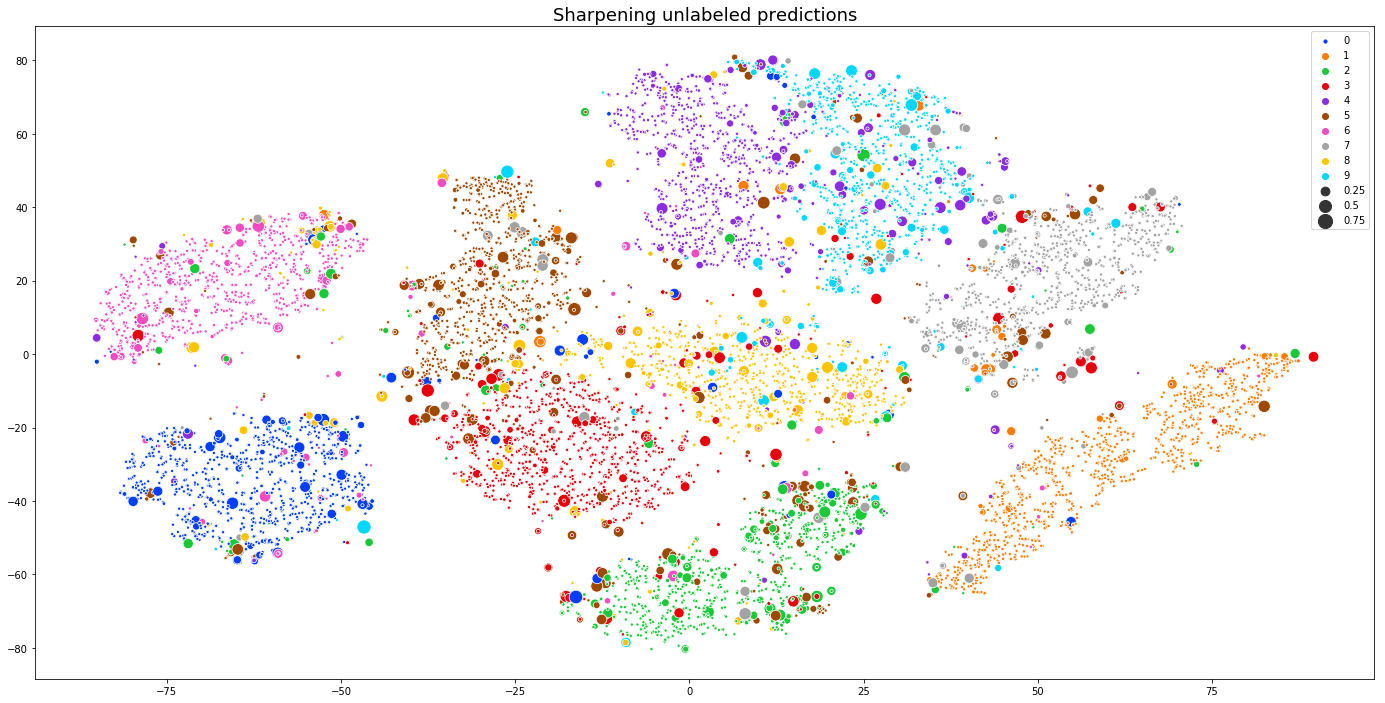

In [61]:
plt.figure(figsize=(24,12))
ax = sns.scatterplot(x=x_tsne[:,0],y=x_tsne[:,1],hue=pred_labels,size=(1-preds),sizes=(10,200),palette=sns.color_palette("bright",10),hue_order=[0,1,2,3,4,5,6,7,8,9])
ax.set_title("Sharpening unlabeled predictions",fontsize=18);

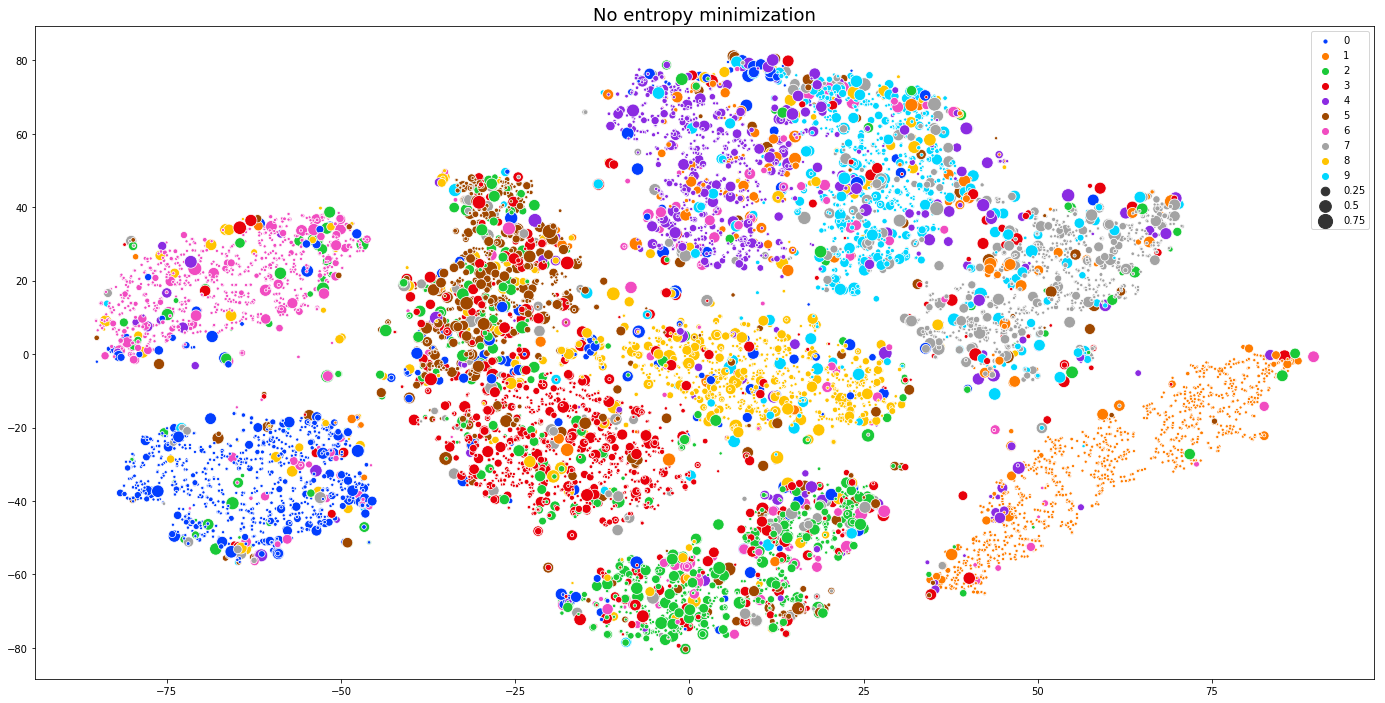

In [62]:
plt.figure(figsize=(24,12))
ax = sns.scatterplot(x=x_tsne[:,0],y=x_tsne[:,1],hue=pred_labels2,size=(1-preds2),sizes=(10,200),palette=sns.color_palette("bright",10),hue_order=[0,1,2,3,4,5,6,7,8,9])
ax.set_title("No entropy minimization",fontsize=18);